## Notebook Introduction
This notebook takes the synthetic example datasets and batches it into four significantly different subsets. A threshold
of 10 weight percent of any given phase is used to batch the data, meaning that if a phase either enters or leaves the
signal (with a threshold of 10 wight percent) the input data will be separated. The notebook then goes a step further
by taking an exemplary INP topas file and editing it such that it will refine a number of basic parameters for a given
batch of the data.

## Installation Instructions
Run the following four cells when running for the first time

In [ ]:
!conda install pandas scipy scikit-learn numpy matplotlib -y

In [ ]:
!conda install diffpy.utils -c diffpy -y

In [13]:
import os
os.chdir('../../')
dir_path = os.getcwd()
dir_path

'C:\\Users\\zacha\\OneDrive\\Desktop\\Github\\dev\\diffpy.nmf_analysis'

Confirm that you are in the diffpy.nmf_mapping folder before running the following line of code

In [14]:
pip install -e .

Obtaining file:///C:/Users/zacha/OneDrive/Desktop/Github/dev/diffpy.nmf_analysis
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py develop for diffpy.nmf-analysis
Note: you may need to restart the kernel to use updated packages.


## Start of the code

In [1]:
import os
import pandas as pd

# In order to use the code below, make sure to install the surrounding package first
from diffpy.nmf_mapping import nmf

bg_mpl_style not found. Using generic matplotlib style.


## Register the directory containing the input files in xy, xye, or dat format. (not not mix and match, make sure it only contains the full batch of data to be processed)

In [2]:
cwd = os.getcwd()

user_edited_input_file_directory_name = 'data/synthetic_r_vs_gr'

input_directory = os.path.join(cwd, user_edited_input_file_directory_name)
input_list, data_list = nmf.load_data(input_directory, xrd=False)

### Repeatedly run the following cell with changes in the NMF_decomposition keyword (varName=varNum) arguments in order to get meaningful structural phases

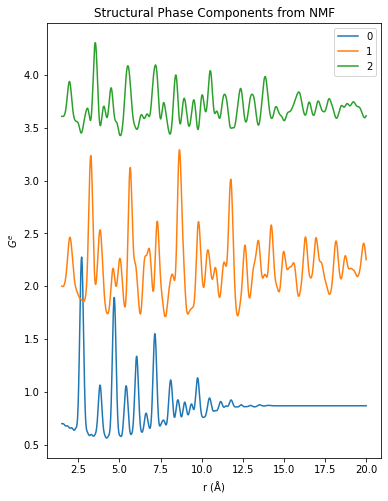

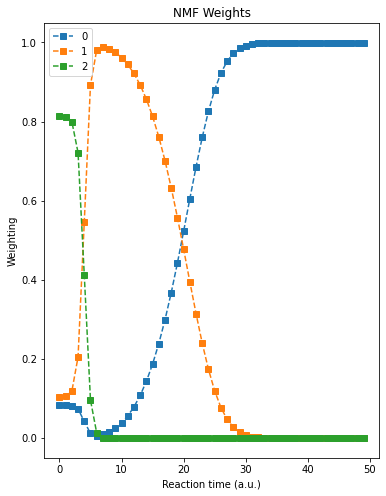

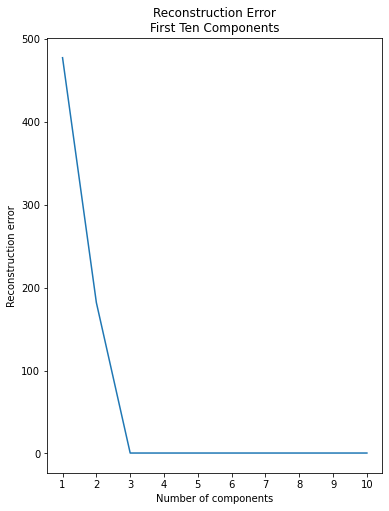

In [3]:
# df_components, df_phase_ratio_timeseries, df_reconstruction_error, df_explained_var_ratio = NMF.NMF_decomposition(input_list, pca_thresh=0.95)

# When not using a PCA threshold, the explained variance variable will not exist. Remove this as one of the function outputs in this case, as shown in the comment below
df_components, df_phase_ratio_timeseries, df_reconstruction_error = nmf.NMF_decomposition(input_list, improve_thresh=0.1)

fig1 = nmf.component_plot(df_components, xrd=False)
fig2 = nmf.component_ratio_plot(df_phase_ratio_timeseries)
fig3 = nmf.reconstruction_error_plot(df_reconstruction_error)
try:
    fig4 = nmf.explained_variance_plot(df_explained_var_ratio)
except:
    pass

## Change "line" variable in following cell to define your threshold
### base this on the NMF weights graph above

In [4]:
line = 0.1


# Shift and concatenate DF columns
df_phase_ratio_timeseries_transposed = df_phase_ratio_timeseries.T
# initialize the shifted dataframe as the initial to get same dimensions
shifted_ratio_df = df_phase_ratio_timeseries_transposed.copy()
for i in range(len(df_phase_ratio_timeseries_transposed.columns)):
    shifted_ratio_df.iloc[:,i] = df_phase_ratio_timeseries_transposed.iloc[:,i].shift(-1)
# append the same dataframe shifted one up to the right of the initial dataframe
conjoined_df = pd.concat([df_phase_ratio_timeseries_transposed, shifted_ratio_df], axis=1)
# conjoined_df.head() # shows top 5 rows, but many more beneath

# Finds where the data crosses the line
num_cols = len(df_phase_ratio_timeseries_transposed.columns)
conjoined_df['total_cross'] = False
for i in range(len(df_phase_ratio_timeseries_transposed.columns)):
    conjoined_df[f'cross_{i}'] = (
        ((conjoined_df.iloc[:,i] >= line) & (conjoined_df.iloc[:,i + num_cols] < line)) |
        ((conjoined_df.iloc[:,i + num_cols] > line) & (conjoined_df.iloc[:,i] <= line)) |
        (conjoined_df.iloc[:,i] == line))
    # adding is equivalend to or-ing the columns
    conjoined_df['total_cross'] = conjoined_df['total_cross'] + conjoined_df[f'cross_{i}']
file_separator_indexes = conjoined_df.index[conjoined_df['total_cross']].to_list()
file_separator_indexes

[4, 12, 25]

### The following cell creates batch folders and separates the data into them based on the threshold from the cell above

In [5]:
from pathlib import Path
from shutil import copy, rmtree
import re

dir = Path(input_directory)
data_list = list(dir.glob('*.xy'))
if len(data_list) == 0:
    data_list = list(dir.glob('*.xye'))
if len(data_list) == 0:
    data_list = list(dir.glob('*.dat'))
if len(data_list) == 0:
    data_list = list(dir.glob('*.gr'))

def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys_file_name(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [atoi(c) for c in re.split(r'(\d+)', text.stem)]

os.chdir(input_directory)
data_list.sort(key=natural_keys_file_name)
separator_count = 0
file_batch = []
for i, file in enumerate(data_list):
    file_batch.append(file)
    if separator_count == len(file_separator_indexes):
        if i == (len(data_list)-1):
            if len(file_batch) > 0:
                new_dir_name = f'batch_{separator_count}'
                if os.path.exists(new_dir_name):
                    rmtree(new_dir_name)
                os.mkdir(new_dir_name)
                for file_to_copy in file_batch:
                    copy(file_to_copy, os.path.join(os.getcwd(), new_dir_name))
                file_batch = []
            break
    elif i == file_separator_indexes[separator_count]:
        new_dir_name = f'batch_{separator_count}'
        if os.path.exists(new_dir_name):
            rmtree(new_dir_name)
        os.mkdir(new_dir_name)
        for file_to_copy in file_batch:
            copy(file_to_copy, os.path.join(os.getcwd(), new_dir_name))
        separator_count += 1
        file_batch = []

### The following cell can be used to edit an INP file from a preliminary refinement on a batch to run a sequential refinement

Note: This example is somewhat nonsensical as an XRD refinement is being performed on PDF data. Please ignore this discrepancy.

### User inputs
The user should edit the first three variables below in order to specify the INP filename, the batch directory name, and the output INP filename

In [6]:
import os
import re
from pathlib import Path


# End user should edit the following variables
user_set_INP_filename = 'example.INP'
User_set_batch_directory_name = 'batch_0'
user_set_output_INP_filename = 'edited.INP'


# No end-user editing required below this comment

data_directory = os.path.join(cwd, 'data')
INP_file_for_editing = os.path.join(data_directory, user_set_INP_filename)

with open(INP_file_for_editing, 'r') as file:
    data = file.read()

print('='*50)
print('\tFile contents prior to editing')
print('='*50)
print(data)

batch_directory = os.path.join(cwd, os.path.join('data/synthetic_r_vs_gr', User_set_batch_directory_name))

phase_pattern = re.compile(r'(?<=")(.*?)(?=")')

str_split_pattern = re.compile(r'(?<=str)(.*?)(?=str)|(?<=str)(.*?)$', flags=re.S)

mvw_pattern = re.compile(r'(?<=MVW\()(.*)(?=\))')

float_pattern = r'\d+[.e][^,]+'

float_pattern_with_space = r'\s*\d+[.e][^,]+'

three_float_pattern = re.compile(fr'({float_pattern}),\s*({float_pattern}),\s*({float_pattern})')

subsections_indices_string_tuple = [(i.span(), i.group()) for i in str_split_pattern.finditer(data)]

mutable_file = list(data)

parameter_tuple_list = []
phase_list = []

for indices, sub_string in reversed(subsections_indices_string_tuple):
    # lists are mutable, strings are not
    mutable_string = list(sub_string)
    # the following finds the phase name and removes any dash
    phase_name = re.search(phase_pattern, sub_string).group()
    phase_name = phase_name.replace("-", "")
    phase_list.append(phase_name)
    # switch out the mvw section
    mvw_match = re.search(mvw_pattern, sub_string)
    mutable_string[slice(*mvw_match.span())] = re.sub(three_float_pattern, "MW_" + phase_name + r' \1,' + "Vol_" + phase_name + r' \2,' + "wf_" + phase_name + r' \3', mvw_match.group())

    # turn the list back intro a string for upcoming re subs
    newstring = ''.join(mutable_string)

    newstring = re.sub(fr'scale\s*@({float_pattern_with_space})', 'scale scale_' + phase_name + r' \1', newstring)

    a_string = None
    b_string = None
    c_string = None
    al_string = None
    be_string = None
    ga_string = None

    hex_pattern = fr'Hexagonal\(@({float_pattern_with_space}),@\s*({float_pattern})\)'
    tetr_pattern = fr'Tetragonal\(@({float_pattern_with_space}),@\s*({float_pattern})\)'
    trig_pattern = fr'Trigonal\(@({float_pattern_with_space}),@\s*({float_pattern})\)'
    cub_pattern = fr'Cubic\(@({float_pattern_with_space})\)'
    a_pattern = fr'a\s*@({float_pattern_with_space})'
    b_pattern = fr'b\s*@({float_pattern_with_space})'
    c_pattern = fr'c\s*@({float_pattern_with_space})'
    al_pattern = fr'al\s*@({float_pattern_with_space})'
    be_pattern = fr'be\s*@({float_pattern_with_space})'
    ga_pattern = fr'ga\s*@({float_pattern_with_space})'
    if re.search(hex_pattern, newstring) is not None:
        newstring = re.sub(hex_pattern, 'Hexagonal(' + 'a_' + phase_name + r' \1,' + 'c_' + phase_name + r' \2)', newstring)
        a_string, c_string = 'a_' + phase_name, 'c_' + phase_name
    elif re.search(tetr_pattern, newstring) is not None:
        newstring = re.sub(tetr_pattern, 'Tetragonal(' + 'a_' + phase_name + r' \1,' + 'c_' + phase_name + r' \2)', newstring)
        a_string, c_string = 'a_' + phase_name, 'c_' + phase_name
    elif re.search(trig_pattern, newstring) is not None:
        newstring = re.sub(trig_pattern, 'Trigonal(' + 'a_' + phase_name + r' \1,' + 'c_' + phase_name + r' \2)', newstring)
        a_string, c_string = 'a_' + phase_name, 'c_' + phase_name
    elif re.search(cub_pattern, newstring) is not None:
        newstring = re.sub(cub_pattern, 'Cubic(' + 'a_' + phase_name + r' \1)', newstring)
        a_string = 'a_' + phase_name
    else:
        if re.search(a_pattern, newstring) is not None:
            newstring = re.sub(a_pattern, 'a a_' + phase_name + r' \1', newstring)
            a_string = 'a_' + phase_name
        if re.search(b_pattern, newstring) is not None:
            newstring = re.sub(b_pattern, 'b b_' + phase_name + r' \1', newstring)
            b_string = 'b_' + phase_name
        if re.search(c_pattern, newstring) is not None:
            newstring = re.sub(c_pattern, 'c c_' + phase_name + r' \1', newstring)
            c_string = 'c_' + phase_name
        if re.search(al_pattern, newstring) is not None:
            newstring = re.sub(al_pattern, 'al al_' + phase_name + r' \1', newstring)
            al_string = 'al_' + phase_name
        if re.search(be_pattern, newstring) is not None:
            newstring = re.sub(be_pattern, 'be be_' + phase_name + r' \1', newstring)
            be_string = 'be_' + phase_name
        if re.search(ga_pattern, newstring) is not None:
            newstring = re.sub(ga_pattern, 'ga ga_' + phase_name + r' \1', newstring)
            ga_string = 'ga_' + phase_name

    flag_tuple = (a_string, b_string, c_string, al_string, be_string, ga_string)

    parameter_tuple_list.append(flag_tuple)

    mutable_file[slice(*indices)] = newstring

new_file = ''.join(mutable_file)

# add the header without the list of filenames
new_file = re.sub(r'(.*)(xdd )(".*?")',
                   '#ifdef !topas_old_version \n'
                   'Backup_INP\n'
                   'out_file = Concat(String(INP_File), ".INP");\n'
                   'num_runs 126\n'
                   '#list File_Name {\n' +
                   '}\n' +
                   'macro filename { File_Name(Run_Number) }\n'
                   '#endif\n' +
                   r'\2' + 'filename',
                   new_file, flags=re.S)

file_list_section_match = re.search(r'\{\n\}', new_file)

prior_file_list_substring = new_file[:(file_list_section_match.start() + 2)]
post_file_list_substring = new_file[(file_list_section_match.start() + 2):]

# turn the list of files in this batch into a string
dir = Path(batch_directory)
batch_file_list = [str(path) for path in dir.glob('*.gr')]
if len(batch_file_list)==0:
    batch_file_list = [str(path) for path in dir.glob('*.xye')]
newline_separated_filenames = "\n".join(batch_file_list)

# insert the string of filenames into the INP string
new_file = prior_file_list_substring + newline_separated_filenames + post_file_list_substring

# add the footer listing all of the variables to be output
new_file += f'\n\t\t#define write_out\n' \
            f'out_file Concat(String(INP_File##Run_Number),".Out")\n' \
            f'#ifdef write_out\n' \
            f'out "results.txt" append\n' \
            f'Out_String(filename)\n' \
            f'Out(Get (r_wp), " %11.5f")\n' \
            f'Out(Get (gof), " %11.5f")\n'
for phase in phase_list:
    new_file += f'Out(MW_{phase}, "%11.5f")\n' \
                f'Out(vol_{phase}, "%11.5f")\n' \
                f'Out(wf_{phase}, "%11.5f")\n' \
                f'Out(scale_{phase}, "%11.5f")\n'

for parameter_tuple in parameter_tuple_list:
    for parameter in parameter_tuple:
        if parameter is not None:
            new_file += f'Out({parameter}, "%11.5f")\n'
print('='*50)
print('\tFile contents after editing')
print('='*50)
print(new_file)

os.chdir(data_directory)

with open(user_set_output_INP_filename, 'w') as f:
    f.write(new_file)


	File contents prior to editing

r_exp 4.97976698 r_exp_dash 6.57667424 r_wp 75.10388453 r_wp_dash 99.18813163 r_p 68.77349496 r_p_dash 98.59675388 weighted_Durbin_Watson 0.05775867044 gof 15.08180701
iters 100000
xdd "C:\preliminary_fit\file\location.raw"
	r_exp 4.97976698 r_exp_dash 6.57667424 r_wp 75.10388453 r_wp_dash 99.18813163 r_p 68.77349496 r_p_dash 98.59675388 weighted_Durbin_Watson 0.05775867044 gof 15.08180701
	bkg @ 167.2686521 -82.61473108
	LP_Factor( 0)
	Rp 217.5
	Rs 217.5
	lam
		ymin_on_ymax  0.001
		la  0.653817 lo  1.540596 lh  0.501844
		la  0.346183 lo  1.544493 lh  0.626579
	str 
		LVol_FWHM_CS_G_L( 1, 127.3239545, 0.89, 178,,,, 200)
		r_bragg  32.22633601
		phase_MAC 6.377875586
		phase_name "LiO2"
		MVW( 119.5256, 99.19447134, 93.58268467)
		space_group Fm-3m
		scale @ 0.001289256025
		Phase_LAC_1_on_cm( 12.76141706)
		Phase_Density_g_on_cm3( 2.000888366)
		Cubic(@ 4.629092109)
		site O1 num_posns 4 x  0 y  0 z  0 occ O-2  1 beq  0.4
		site Li1 num_posns 8 x  0.2